# Regresi dengan Regularisasi

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Basic Training
Ridge Regression, Lasso

### Load Data

In [2]:
admission = pd.read_csv("/content/drive/MyDrive/DQlab/Machine Learning & AI - Batch 15/Day 5 - Regresi dengan Regularisasi/admission.csv")
admission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gre_score                500 non-null    int64  
 1   toefl_score              500 non-null    int64  
 2   univ_ranking             500 non-null    int64  
 3   motiv_letter_strength    500 non-null    float64
 4   recommendation_strength  500 non-null    float64
 5   gpa                      500 non-null    float64
 6   research_exp             500 non-null    int64  
 7   admission_score          500 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 31.4 KB


### Split Data

In [3]:
# split train test
from sklearn.model_selection import train_test_split

feature = admission.drop(columns='admission_score')
target = admission[['admission_score']]

feature_admit_train, feature_admit_test, target_admit_train, target_admit_test = train_test_split(feature, target, test_size=0.20, random_state=42)

### Multicollinearity Handling

In [4]:
# calculate vif score for each column in feature_admit_train
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

X = add_constant(feature_admit_train)

vif_df = (pd.DataFrame(
            [vif(X.values, i) for i in range(len(X.columns))]
            ,index=X.columns)
            .reset_index())

vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,gre_score,4.489983
2,toefl_score,3.664298
3,univ_ranking,2.572110
4,motiv_letter_strength,2.785764
5,recommendation_strength,1.977698
6,gpa,4.654540
7,research_exp,1.518065


Ada dua fitur dengan VIF score > 4: gre_score dan gpa. Maka kita perlu lakukan correlation analysis.

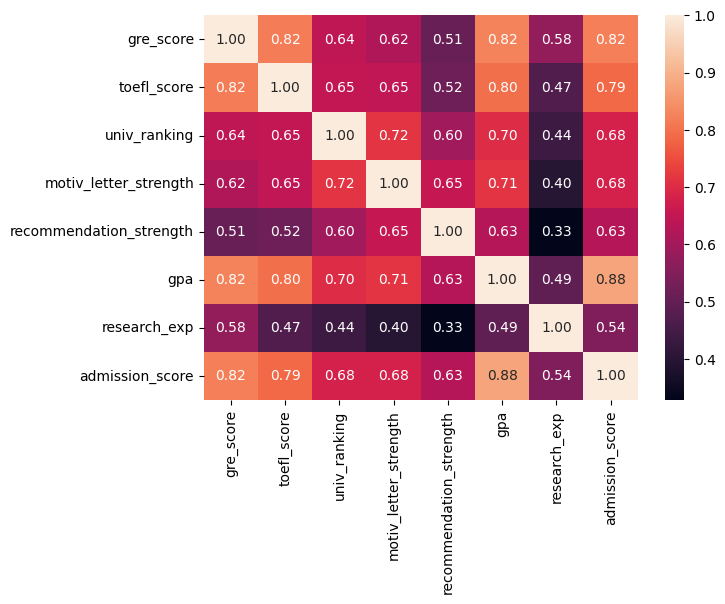

In [5]:
# heatmap correlation
admit_train = pd.concat([feature_admit_train, target_admit_train], axis=1)
corr = admit_train.corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Need to drop:
* gre_score
* toefl_score

In [6]:
# drop fitur yang redundan
feature_admit_train = feature_admit_train.drop(columns=['gre_score','toefl_score'])
feature_admit_test = feature_admit_test.drop(columns=['gre_score','toefl_score'])

In [7]:
# recheck VIF score (optional)
X = add_constant(feature_admit_train)

vif_df = (pd.DataFrame(
            [vif(X.values, i) for i in range(len(X.columns))]
            ,index=X.columns)
            .reset_index())

vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,univ_ranking,2.511407
2,motiv_letter_strength,2.748278
3,recommendation_strength,1.965542
4,gpa,2.726281
5,research_exp,1.350514


### Transform to Numpy

In [9]:
# transform ke numpy array
# train the model
X_admit_train = feature_admit_train.to_numpy()
y_admit_train = target_admit_train.to_numpy().ravel()

### Ridge Regression

In [10]:
from sklearn.linear_model import Ridge

# define the model
ridge_reg = Ridge(alpha=10,
                  random_state=42)

# train model
ridge_reg.fit(X_admit_train, y_admit_train)

Ridge(alpha=10, random_state=42)

In [11]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_admit_train
model = ridge_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,-60.841521
1,univ_ranking,1.116250
2,motiv_letter_strength,0.951559
3,recommendation_strength,1.705587
4,gpa,13.804175
5,research_exp,3.878495


## Lasso

In [12]:
from sklearn.linear_model import Lasso

# define the model
lasso_reg = Lasso(alpha=10,
                  random_state=42)

# train
lasso_reg.fit(X_admit_train, y_admit_train)

Lasso(alpha=10, random_state=42)

In [13]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_admit_train
model = lasso_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,70.120396
1,univ_ranking,0.726780
2,motiv_letter_strength,0.000000
3,recommendation_strength,0.000000
4,gpa,0.000000
5,research_exp,0.000000


## Proper Modeling Flow
Dengan pemilihan lambda optimal

### Split data: train-validation-test

In [14]:
# split train test
from sklearn.model_selection import train_test_split

feature = admission.drop(columns='admission_score')
target = admission[['admission_score']]

# First splitting: pretrain and test
feature_admit_pretrain, feature_admit_test, target_admit_pretrain, target_admit_test = train_test_split(feature, target, test_size=0.20, random_state=42)

# Second splitting: train and validation
feature_admit_train, feature_admit_validation, target_admit_train, target_admit_validation = train_test_split(feature_admit_pretrain, target_admit_pretrain, test_size=0.20, random_state=42)

## Drop Multicollinear Features

In [15]:
feature_admit_train = feature_admit_train.drop(columns=['gre_score','toefl_score'])
feature_admit_validation = feature_admit_validation.drop(columns=['gre_score','toefl_score'])
feature_admit_test = feature_admit_test.drop(columns=['gre_score','toefl_score'])

## Train Multiple Models
with different alpha (lambda)

In [16]:
# convert to numpy array
X_admit_train = feature_admit_train.to_numpy()
y_admit_train = target_admit_train.to_numpy().ravel()

In [17]:
from sklearn.linear_model import Ridge

# define the model
# multiple models with different alphas (lambda)
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)
ridge_reg_hundred = Ridge(alpha=100, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_admit_train, y_admit_train)
ridge_reg_pointone.fit(X_admit_train, y_admit_train)
ridge_reg_one.fit(X_admit_train, y_admit_train)
ridge_reg_ten.fit(X_admit_train, y_admit_train)
ridge_reg_hundred.fit(X_admit_train, y_admit_train)

Ridge(alpha=100, random_state=42)

## Find the best model (alpha)
Based on validation set

In [18]:
from sklearn.metrics import mean_squared_error

X_admit_validation = feature_admit_validation.to_numpy()
y_admit_validation = target_admit_validation.to_numpy().ravel()

alphas = [0.01, 0.1, 1., 10, 100]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten,
          ridge_reg_hundred]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_admit_validation)
    rmse = np.sqrt(mean_squared_error(y_admit_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 5.708245252022861
RMSE of Ridge regression model with alpha = 0.1 is 5.710008557214604
RMSE of Ridge regression model with alpha = 1.0 is 5.728594095060177
RMSE of Ridge regression model with alpha = 10 is 5.959487390063002
RMSE of Ridge regression model with alpha = 100 is 7.214013081941181


We can see that Ridge with `alpha=0.01` has the smalles RMSE --> The best model

### Coefficients

In [19]:
ridge_best = ridge_reg_pointzeroone

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_admit_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,-74.592291
1,univ_ranking,0.564690
2,motiv_letter_strength,0.962605
3,recommendation_strength,1.560816
4,gpa,15.616335
5,research_exp,4.271438


# Lasso!
Exercise!

## Model Evaluation
The Best Ridge Regression

### Training Error

In [20]:
# prepare prediction result on train data
y_predict_train = ridge_best.predict(X_admit_train)

In [21]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(root_mean_squared_error(y_admit_train, y_predict_train)))
print('MAE for training data is {}'.format(mean_absolute_error(y_admit_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_admit_train, y_predict_train)))

RMSE for training data is 6.467532067866163
MAE for training data is 4.710620088428336
MAPE for training data is 0.0764225230243602


### Testing Error

In [22]:
# prepare prediction result on test data
X_admit_test = feature_admit_test.to_numpy()
y_predict_test = ridge_best.predict(X_admit_test)

# ground truth target
y_admit_test = target_admit_test.to_numpy().ravel()

In [23]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(root_mean_squared_error(y_admit_test, y_predict_test)))
print('MAE for testing data is {}'.format(mean_absolute_error(y_admit_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_admit_test, y_predict_test)))

RMSE for testing data is 5.905101530658202
MAE for testing data is 3.966703923077081
MAPE for testing data is 0.06464085042830202


Quiz: apakah model kita underfit? overfit? just right?

# Selesai